# Import libraries

In [1]:
#Import data packages
import os
import sys
import glob
import numpy as np
import pandas as pd
from google.colab import drive

#Import audio packages
import librosa
import librosa.display
from scipy.io import wavfile
import scipy.io.wavfile
import sys

#Import plotting packages
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import matplotlib.pyplot as plt
import seaborn as sns

#Import Keras & Tensorflow packages
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

## Read CREMA-D Dataset

In [2]:
#Build list of files

# Mount Google Drive
drive.mount('/content/drive')

# Directory path to your dataset
dataset_path = '/content/drive/MyDrive/AudioWAV/'

rawdata_list = os.listdir(dataset_path)



Mounted at /content/drive


In [3]:
#Review list of files
print(rawdata_list)

['1079_TSI_SAD_XX.wav', '1079_TAI_SAD_XX.wav', '1079_TAI_HAP_XX.wav', '1080_IEO_NEU_XX.wav', '1079_ITH_HAP_XX.wav', '1079_TSI_NEU_XX.wav', '1079_IWW_DIS_XX.wav', '1079_IOM_FEA_XX.wav', '1079_IWL_ANG_XX.wav', '1080_IEO_HAP_LO.wav', '1079_DFA_NEU_XX.wav', '1079_IOM_SAD_XX.wav', '1079_IEO_ANG_HI.wav', '1079_DFA_FEA_XX.wav', '1079_IEO_ANG_MD.wav', '1079_IEO_SAD_LO.wav', '1079_TAI_FEA_XX.wav', '1079_IWW_SAD_XX.wav', '1080_DFA_HAP_XX.wav', '1079_IEO_HAP_MD.wav', '1080_IEO_FEA_HI.wav', '1080_IEO_FEA_MD.wav', '1079_IEO_DIS_MD.wav', '1079_IEO_HAP_LO.wav', '1080_IEO_HAP_MD.wav', '1079_IEO_NEU_XX.wav', '1079_IEO_ANG_LO.wav', '1079_IEO_FEA_HI.wav', '1079_IEO_HAP_HI.wav', '1079_IWW_ANG_XX.wav', '1079_IEO_DIS_HI.wav', '1079_DFA_HAP_XX.wav', '1079_IEO_FEA_MD.wav', '1079_IWW_NEU_XX.wav', '1079_DFA_SAD_XX.wav', '1080_WSI_DIS_XX.wav', '1081_ITS_DIS_XX.wav', '1080_WSI_FEA_XX.wav', '1080_TIE_SAD_XX.wav', '1080_ITH_ANG_XX.wav', '1080_IOM_SAD_XX.wav', '1080_IWL_FEA_XX.wav', '1080_TIE_ANG_XX.wav', '1080_MTI_

## LIbrosa & MFCC configuration
In order to analyze and standardize how each audio file feature was built, the following configurations were determined:

In [4]:
#sample feature
#librosa.core.load(path, sr=22050, mono=True, offset=0.0, duration=None, dtype=<class 'numpy.float32'>, res_type='kaiser_best')
res_type_s = 'kaiser_best'
duration_s = None
sample_rate_s = 22050
offset_s = 0.5

#Mfcc
#librosa.feature.mfcc(y=None, sr=22050, S=None, n_mfcc=20, dct_type=2, norm='ortho', lifter=0, **kwargs)
mfcc_sample_rate = 22050
n_mfcc = 40
axis_mfcc = 1

### CREMA-D get emotion features

In [5]:
# Create empty lists for emotions and file paths
file_emotion = []
file_paths = []

# Iterate through all files in the directory
for file_name in os.listdir(dataset_path):
    # Construct the full file path
    file_path_full = os.path.join(dataset_path, file_name)

    # Check if the file is an audio file (assuming WAV format)
    if file_name.lower().endswith('.wav') and os.path.isfile(file_path_full):
        # storing file paths
        file_paths.append(file_path_full)

        # storing file emotions
        part = file_name.split('_')
        if part[2] == 'SAD':
            file_emotion.append('sad')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')

In [6]:
#Check list
file_emotion

['sad',
 'sad',
 'happy',
 'neutral',
 'happy',
 'neutral',
 'disgust',
 'fear',
 'angry',
 'happy',
 'neutral',
 'sad',
 'angry',
 'fear',
 'angry',
 'sad',
 'fear',
 'sad',
 'happy',
 'happy',
 'fear',
 'fear',
 'disgust',
 'happy',
 'happy',
 'neutral',
 'angry',
 'fear',
 'happy',
 'angry',
 'disgust',
 'happy',
 'fear',
 'neutral',
 'sad',
 'disgust',
 'disgust',
 'fear',
 'sad',
 'angry',
 'sad',
 'fear',
 'angry',
 'disgust',
 'sad',
 'sad',
 'fear',
 'disgust',
 'fear',
 'disgust',
 'sad',
 'angry',
 'sad',
 'disgust',
 'sad',
 'angry',
 'disgust',
 'fear',
 'sad',
 'neutral',
 'neutral',
 'fear',
 'sad',
 'angry',
 'disgust',
 'angry',
 'neutral',
 'fear',
 'sad',
 'sad',
 'neutral',
 'angry',
 'angry',
 'disgust',
 'happy',
 'neutral',
 'neutral',
 'angry',
 'sad',
 'sad',
 'fear',
 'happy',
 'neutral',
 'happy',
 'disgust',
 'sad',
 'happy',
 'neutral',
 'disgust',
 'neutral',
 'angry',
 'disgust',
 'fear',
 'neutral',
 'angry',
 'angry',
 'sad',
 'disgust',
 'happy',
 'sad'

In [7]:
#Turn list into dataframe
labels = pd.DataFrame(file_emotion)

In [8]:
#Check shape
labels.shape

(7442, 1)

In [9]:
#Change index name to "emotion"
labels = labels.rename({0: 'emotion'}, axis=1)

In [10]:
labels.shape

(7442, 1)

In [11]:
#Count the number of files per emotion
labels_total = pd.DataFrame(labels.groupby(['emotion']).size())
labels_total

,0
emotion,
angry,1271
disgust,1271
fear,1271
happy,1271
neutral,1087
sad,1271


### CREMA-D get audio features with librosa library

In [12]:

rawdata_crema = pd.DataFrame(columns=['feature'])
bookmark=0

for y in rawdata_list:
    #Change to kaiser_best & 22050 kHz
    #sr > target sampling rate
    #offset=0.5
    X, sample_rate = librosa.load(dataset_path+y,
                                  #res_type = res_type_s,
                                  duration = duration_s,
                                  sr = sample_rate_s,
                                  offset = offset_s)
    sample_rate = np.array(sample_rate)

    #Get MFCCs from each file
    mfccs = librosa.feature.mfcc(   y=X,
                                    sr = mfcc_sample_rate,
                                    n_mfcc = n_mfcc)

    #Calculate mean of MFCCs
    mfccs_mean = np.mean(    mfccs,
                             axis = axis_mfcc)
    feature = mfccs_mean

    #Add MFCCs feature results to list
    rawdata_crema.loc[bookmark] = [feature]
    bookmark=bookmark+1

In [13]:
#Verity data results
rawdata_crema.shape

(7442, 1)

In [14]:
#Verify that there are no null values
rawdata_crema.isnull().values.any()

False

In [15]:
# See array sample of features
rawdata_crema

,feature
0,"[-401.27618, 116.6272, 0.4886315, 65.94333, -1..."
1,"[-440.3175, 136.1579, 17.228382, 53.991688, -1..."
2,"[-336.42755, 130.65514, -8.090638, 32.9309, -2..."
3,"[-423.00467, 143.03592, 17.47734, 53.278305, -..."
4,"[-280.05576, 132.73538, -28.700256, 43.12981, ..."
...,...
7437,"[-377.3721, 113.41995, -11.465235, 56.656616, ..."
7438,"[-328.42282, 110.86818, 2.3822556, 48.353325, ..."
7439,"[-426.9764, 146.13885, 8.116817, 60.140743, -1..."
7440,"[-419.2845, 152.66829, 11.293661, 48.45641, -1..."


In [16]:
#Turn array into dataframe
rawdata_crema_final = pd.DataFrame(rawdata_crema['feature'].values.tolist())

In [17]:
#Analyze new dataframe shape
rawdata_crema_final.shape

(7442, 40)

In [18]:
# Check data sample
rawdata_crema_final.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,-401.276184,116.627197,0.488631,65.943329,-15.709269,28.724207,-23.616907,20.389484,-10.850453,7.325027,...,-1.203651,-0.731227,3.753484,-0.800356,1.926378,-2.219066,3.967894,-2.532324,0.347068,-2.472679
1,-440.317505,136.157898,17.228382,53.991688,-18.900448,28.544437,-13.570517,17.130178,-9.342173,4.956460,...,4.080382,5.024942,6.884963,1.219177,4.790305,-0.792396,2.715257,-2.859335,0.200690,-2.322478
2,-336.427551,130.655136,-8.090638,32.930901,-21.860416,9.873055,-1.471236,3.231654,-10.445426,7.342981,...,0.563780,-1.886652,3.175590,0.474181,1.796705,2.056330,6.073338,2.293361,1.269413,-0.963245
3,-423.004669,143.035919,17.477341,53.278305,-22.395697,26.474735,-11.077620,15.134370,-14.765268,0.363165,...,1.881677,-0.059180,2.132954,-1.283618,2.189487,-1.657856,3.336865,-2.207319,2.236426,-1.409023
4,-280.055756,132.735382,-28.700256,43.129810,-15.997142,-3.942923,-17.287367,-0.249551,-11.239864,-2.474944,...,3.390780,-0.503597,2.462493,-1.668408,2.592176,3.233632,4.557814,0.679704,-1.949862,0.548606


In [19]:
#Join labels with features
newdf_crema = pd.concat([rawdata_crema_final,labels], axis=1)

In [20]:
#Rename dataframe
newdf_crema = newdf_crema.rename(index=str, columns={"0": "label"})

In [21]:
#Analyze dataframe shape
newdf_crema.shape

(7442, 41)

In [22]:
#Anayze dataframe sample
newdf_crema.head()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
0,-401.276184,116.627197,0.488631,65.943329,-15.709269,28.724207,-23.616907,20.389484,-10.850453,7.325027,...,-0.731227,3.753484,-0.800356,1.926378,-2.219066,3.967894,-2.532324,0.347068,-2.472679,sad
1,-440.317505,136.157898,17.228382,53.991688,-18.900448,28.544437,-13.570517,17.130178,-9.342173,4.956460,...,5.024942,6.884963,1.219177,4.790305,-0.792396,2.715257,-2.859335,0.200690,-2.322478,sad
2,-336.427551,130.655136,-8.090638,32.930901,-21.860416,9.873055,-1.471236,3.231654,-10.445426,7.342981,...,-1.886652,3.175590,0.474181,1.796705,2.056330,6.073338,2.293361,1.269413,-0.963245,happy
3,-423.004669,143.035919,17.477341,53.278305,-22.395697,26.474735,-11.077620,15.134370,-14.765268,0.363165,...,-0.059180,2.132954,-1.283618,2.189487,-1.657856,3.336865,-2.207319,2.236426,-1.409023,neutral
4,-280.055756,132.735382,-28.700256,43.129810,-15.997142,-3.942923,-17.287367,-0.249551,-11.239864,-2.474944,...,-0.503597,2.462493,-1.668408,2.592176,3.233632,4.557814,0.679704,-1.949862,0.548606,happy


In [23]:
#Datafram drop Nan values
newdf_crema.dropna(inplace=True)

In [24]:
from sklearn.utils import shuffle

#Shuffle dataframe
newdf_crema = shuffle(newdf_crema)
newdf_crema.head(10)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
3208,-366.728699,107.637077,11.791833,57.384964,-8.991070,24.605909,-16.794594,3.607896,-15.286947,-3.327157,...,1.886808,2.145638,-1.017144,4.220940,1.462001,6.121615,1.212873,2.720433,-0.640458,neutral
527,-390.626740,108.024590,4.215102,58.080059,-8.202668,31.427996,-20.364540,13.107589,-11.269541,3.224380,...,-0.064194,3.284230,-2.105689,3.030960,-3.308507,1.983232,-4.003192,0.101634,-1.438046,happy
615,-401.594879,160.462860,-4.000437,48.063576,-19.098747,20.662193,-14.738647,10.836534,-19.811283,2.841086,...,-4.137050,-0.670074,-2.157455,1.965694,-2.596089,4.460764,-4.232629,0.429815,-1.982600,happy
4170,-229.566422,96.714180,-12.324722,34.107639,-5.295344,11.946206,-21.620321,0.826717,-11.728529,-2.296040,...,1.902363,4.623035,-0.584554,0.407941,-1.916266,1.483009,0.788271,3.259355,-1.041606,angry
425,-460.682983,145.472961,4.002129,62.817707,-12.025769,30.466318,-15.150441,11.490016,-8.513606,-0.214220,...,-1.917096,-0.181224,-4.627484,2.711250,-4.245417,1.170625,-3.221954,1.649137,-2.479921,sad
4903,-369.448181,141.542023,18.316589,35.477825,-9.844412,13.226587,-15.346713,-1.568887,-13.915609,1.941121,...,-0.280903,3.187461,0.142420,1.899945,-1.117013,-0.887605,-3.019456,-0.084475,1.098372,happy
916,-352.300995,142.232162,0.527161,39.605125,-20.956831,24.517838,-27.047977,11.980304,-14.833712,-4.997319,...,-2.300211,-0.838398,-3.067727,-0.169506,-4.259041,2.136637,-5.113431,1.043161,-1.916086,disgust
5434,-323.104767,134.632858,7.864331,32.923000,-18.372860,18.205040,-19.888212,4.372001,-22.531534,-4.626930,...,-3.106479,-0.148669,-0.389333,1.700486,-0.703687,3.453956,-2.373017,0.274175,0.124325,happy
3132,-434.707123,149.359116,1.933442,55.841694,-13.875171,31.992767,-22.195246,15.371636,-11.134335,5.796217,...,1.178326,5.246430,-0.730657,4.327293,0.071754,6.701046,1.228541,4.395581,1.266882,sad
1371,-425.341980,143.213501,17.314913,57.028038,-6.254431,19.696144,-12.844302,6.724236,-11.519960,2.822818,...,1.404900,2.954203,-2.408269,0.690986,-4.097876,2.122435,-1.021696,1.002432,1.867895,sad


In [25]:
#Verify that there are no null values
newdf_crema.isnull().values.any()

False

In [26]:
# Check dataframe sample
newdf_crema.head(5)

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
3208,-366.728699,107.637077,11.791833,57.384964,-8.991070,24.605909,-16.794594,3.607896,-15.286947,-3.327157,...,1.886808,2.145638,-1.017144,4.220940,1.462001,6.121615,1.212873,2.720433,-0.640458,neutral
527,-390.626740,108.024590,4.215102,58.080059,-8.202668,31.427996,-20.364540,13.107589,-11.269541,3.224380,...,-0.064194,3.284230,-2.105689,3.030960,-3.308507,1.983232,-4.003192,0.101634,-1.438046,happy
615,-401.594879,160.462860,-4.000437,48.063576,-19.098747,20.662193,-14.738647,10.836534,-19.811283,2.841086,...,-4.137050,-0.670074,-2.157455,1.965694,-2.596089,4.460764,-4.232629,0.429815,-1.982600,happy
4170,-229.566422,96.714180,-12.324722,34.107639,-5.295344,11.946206,-21.620321,0.826717,-11.728529,-2.296040,...,1.902363,4.623035,-0.584554,0.407941,-1.916266,1.483009,0.788271,3.259355,-1.041606,angry
425,-460.682983,145.472961,4.002129,62.817707,-12.025769,30.466318,-15.150441,11.490016,-8.513606,-0.214220,...,-1.917096,-0.181224,-4.627484,2.711250,-4.245417,1.170625,-3.221954,1.649137,-2.479921,sad


In [27]:
#Analyz shape of dataframe
newdf_crema.shape

(7442, 41)

In [28]:
# see number of emotions
newdf_crema[newdf_crema.columns[-1]].nunique()

6

# Dividing the data into test and train

In [29]:
#Split features from targets
X = newdf_crema.iloc[:,:-1]

#Split targets
y = newdf_crema.iloc[:,-1]

In [30]:
#Get sample of target
y

3208    neutral
527       happy
615       happy
4170      angry
425         sad
         ...   
1003      happy
3555    disgust
844       angry
3844        sad
1522      angry
Name: emotion, Length: 7442, dtype: object

In [31]:
#Get sample of features
X

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
3208,-366.728699,107.637077,11.791833,57.384964,-8.991070,24.605909,-16.794594,3.607896,-15.286947,-3.327157,...,1.755134,1.886808,2.145638,-1.017144,4.220940,1.462001,6.121615,1.212873,2.720433,-0.640458
527,-390.626740,108.024590,4.215102,58.080059,-8.202668,31.427996,-20.364540,13.107589,-11.269541,3.224380,...,-2.981494,-0.064194,3.284230,-2.105689,3.030960,-3.308507,1.983232,-4.003192,0.101634,-1.438046
615,-401.594879,160.462860,-4.000437,48.063576,-19.098747,20.662193,-14.738647,10.836534,-19.811283,2.841086,...,-1.314071,-4.137050,-0.670074,-2.157455,1.965694,-2.596089,4.460764,-4.232629,0.429815,-1.982600
4170,-229.566422,96.714180,-12.324722,34.107639,-5.295344,11.946206,-21.620321,0.826717,-11.728529,-2.296040,...,1.829034,1.902363,4.623035,-0.584554,0.407941,-1.916266,1.483009,0.788271,3.259355,-1.041606
425,-460.682983,145.472961,4.002129,62.817707,-12.025769,30.466318,-15.150441,11.490016,-8.513606,-0.214220,...,-2.766358,-1.917096,-0.181224,-4.627484,2.711250,-4.245417,1.170625,-3.221954,1.649137,-2.479921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,-361.121735,146.289734,3.614116,53.964718,-12.083884,25.558020,-21.603903,-0.115238,-11.458217,4.514758,...,2.131970,-2.648484,1.716066,-0.284699,5.000941,-1.116518,1.378547,-2.084351,1.777814,1.765676
3555,-434.595367,134.864807,16.145369,64.898354,-19.800213,32.970524,-19.363224,14.565809,-14.387173,5.620512,...,1.138080,0.257385,2.570598,-2.656171,3.081578,-1.458926,4.408321,-1.084905,2.575683,-1.249159
844,-323.929871,125.393501,-14.119441,41.394466,-19.457842,22.367985,-23.599081,7.568679,-12.756754,9.965456,...,-3.701397,-0.548749,0.215156,-4.133747,1.038813,-3.401639,2.360284,-3.475915,1.233413,-3.321869
3844,-443.326538,159.677109,5.947620,58.897465,-14.991687,27.789991,-20.882900,16.399492,-10.887652,6.410676,...,0.271959,1.141377,4.791517,-0.682924,3.673973,-2.444002,3.593509,-1.677810,2.084176,-1.565311


In [32]:
from sklearn.model_selection import train_test_split

#Split train & test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    random_state=1)

# Check out the data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (6697, 40)
y_train shape: (6697,)
X_test shape: (745, 40)
y_test shape: (745,)


In [33]:
#Check unique values for y_test
y_test.unique()

array(['angry', 'neutral', 'sad', 'disgust', 'fear', 'happy'],
      dtype=object)

In [34]:
#Check unique values for y_train
y_train.unique()

array(['fear', 'happy', 'angry', 'neutral', 'sad', 'disgust'],
      dtype=object)

In [35]:
#Label Encoding
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()

#Encode emotion labels into numbers
y_train_lb = to_categorical(lb.fit_transform(y_train))
y_test_lb = to_categorical(lb.fit_transform(y_test))

# Check out the data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train_lb.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test_lb.shape}')

X_train shape: (6697, 40)
y_train shape: (6697, 6)
X_test shape: (745, 40)
y_test shape: (745, 6)


In [36]:
#Check encoding
np.unique(y_train_lb, axis=0)

array([[0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [37]:
# range of x values
print(f'X range: {X_train.min()}-{X_train.max()}')
# y unique values
print(f'y values: {np.unique(y_train_lb)}')
num_classes = len(np.unique(y_train_lb))
print(f'Number of classes: {num_classes}')

X range: 0    -1131.370972
1        0.000000
2      -68.648979
3        0.000000
4      -62.631050
5      -25.226515
6      -48.690350
7      -15.034385
8      -36.962631
9      -13.424578
10     -16.950233
11     -21.176552
12     -13.157248
13     -20.773066
14     -11.182362
15     -32.811802
16     -14.977754
17     -23.285896
18     -13.050726
19     -19.889174
20     -16.816936
21     -11.525985
22     -15.386575
23      -9.244330
24     -13.768227
25      -5.063878
26     -12.753765
27      -7.368147
28      -9.844577
29      -8.949030
30      -9.352777
31     -11.936197
32      -7.366942
33     -10.518728
34      -7.454338
35     -11.204182
36      -5.823586
37      -9.298220
38      -6.263975
39      -6.371147
dtype: float32-0     -97.526924
1     170.880264
2      37.123898
3      87.653427
4      17.578312
5      67.757523
6       7.014558
7      33.372646
8       0.000000
9      19.608679
10     27.741692
11     18.555363
12     31.176781
13     14.499504
14     24.282417
1

## Build list of labels to build confusion matrix after model

In [38]:
#Check encoding labels
lb.classes_

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
      dtype=object)

In [39]:
#Build new lists of encoding labels
y_labels_encoded = {}
for i, label in enumerate(lb.classes_):
    y_labels_encoded[i] = label

y_labels_encoded

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad'}

# Scale data for analysis

In [40]:
from sklearn.preprocessing import StandardScaler
#Normalize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scalled = scaler.transform(X_train)
X_test_scalled = scaler.transform(X_test)

# Build model - Convolution Neural Network

### Change dimensions for CNN model

In [41]:
#Add dimension for CNN
x_traincnn = np.expand_dims(X_train_scalled, axis=2)
x_testcnn = np.expand_dims(X_test_scalled, axis=2)

#Check shapes of dataframes
print(x_traincnn.shape)
print(x_testcnn.shape)

(6697, 40, 1)
(745, 40, 1)


In [42]:
#Import packages for CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv1D
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, BatchNormalization, Flatten, MaxPooling2D

In [43]:
#Build sequential CNN
CNN_model = Sequential()

#Build first layer
CNN_model.add(Conv1D(32, 5,padding='same',
                 input_shape=(40, 1), activation='relu'))

#Build second layer
CNN_model.add(Conv1D(128, 5,padding='same',activation='relu'))

#Build third layer
CNN_model.add(Conv1D(64, 5,padding='same',activation='relu'))

#Build forth layer
CNN_model.add(Conv1D(32, 5,padding='same',activation='relu'))

#Add dropout
#CNN_model.add(Dropout(0.1))

#Flatten
CNN_model.add(Flatten())

CNN_model.add(Dense(128, activation ='relu'))
CNN_model.add(Dropout(0.1))
CNN_model.add(Dense(64, activation ='relu'))
CNN_model.add(Dense(6, activation='softmax'))

In [44]:
#Look at CNN model summary
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 32)            192       
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 128)           20608     
                                                                 
 conv1d_2 (Conv1D)           (None, 40, 64)            41024     
                                                                 
 conv1d_3 (Conv1D)           (None, 40, 32)            10272     
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0

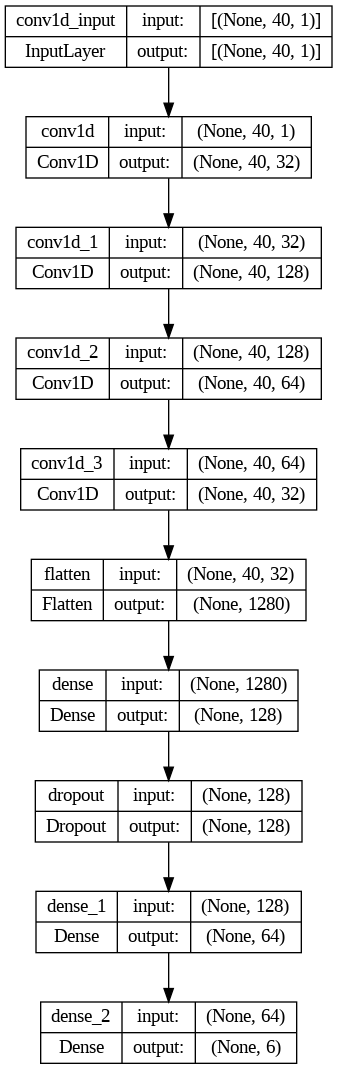

In [45]:
from keras.utils import plot_model

# Save an image of the model's architecture to a file
plot_model(CNN_model, to_file='Feed Forward NN.png', show_shapes=True, show_layer_names=True)

In [46]:
# Compile the model with the desired loss function, optimizer, and metric to optimize
CNN_model.compile(loss = 'categorical_crossentropy',
                  optimizer = 'Adam',
                  metrics = ['accuracy'])

In [47]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.basic_cnn.hdf5',
                               verbose=1, save_best_only=True)

#Model fit
cnn_results = CNN_model.fit(x_traincnn, y_train_lb,
              batch_size = 16,
              epochs = 50,
              verbose = 1,
              validation_data = (x_testcnn, y_test_lb))

Epoch 1/50
419/419 [==============================] - 17s 7ms/step - loss: 1.4938 - accuracy: 0.3796 - val_loss: 1.3358 - val_accuracy: 0.4752
Epoch 2/50
419/419 [==============================] - 2s 6ms/step - loss: 1.3481 - accuracy: 0.4578 - val_loss: 1.3019 - val_accuracy: 0.4886
Epoch 3/50
419/419 [==============================] - 3s 6ms/step - loss: 1.2623 - accuracy: 0.4944 - val_loss: 1.2662 - val_accuracy: 0.4980
Epoch 4/50
419/419 [==============================] - 3s 8ms/step - loss: 1.1682 - accuracy: 0.5392 - val_loss: 1.3153 - val_accuracy: 0.4872
Epoch 5/50
419/419 [==============================] - 3s 7ms/step - loss: 1.0661 - accuracy: 0.5780 - val_loss: 1.3390 - val_accuracy: 0.4926
Epoch 6/50
419/419 [==============================] - 2s 6ms/step - loss: 0.9430 - accuracy: 0.6340 - val_loss: 1.3434 - val_accuracy: 0.4926
Epoch 7/50
419/419 [==============================] - 2s 6ms/step - loss: 0.8152 - accuracy: 0.6842 - val_loss: 1.4133 - val_accuracy: 0.4846
Epoch

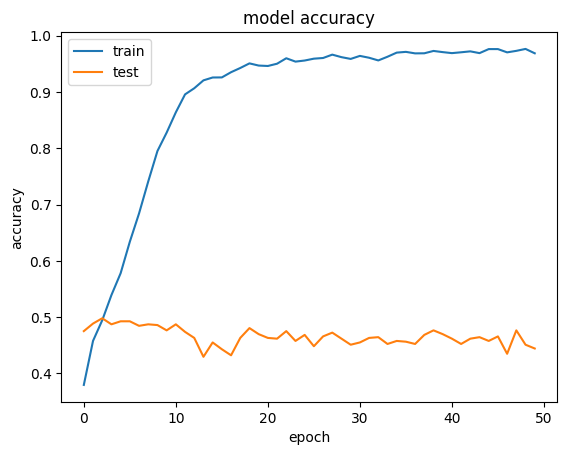

In [48]:
#Plot model accuracy over ephocs
plt.plot(cnn_results.history['accuracy'])
plt.plot(cnn_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

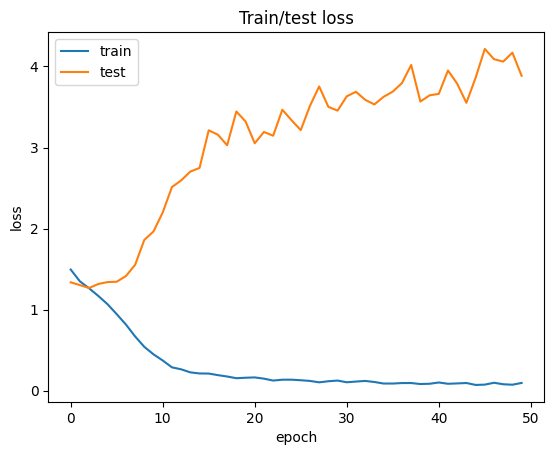

In [49]:
#Plot model accuracy over ephocs
plt.plot(cnn_results.history['loss'])
plt.plot(cnn_results.history['val_loss'])
plt.title('Train/test loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
# Calculate pre-training accuracy
score = CNN_model.evaluate(x_testcnn, y_test_lb, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

24/24 [==============================] - 0s 4ms/step - loss: 3.8849 - accuracy: 0.4443
Pre-training accuracy: 44.4295%


In [51]:
# Evaluating the model on the training and testing set
score = CNN_model.evaluate(x_traincnn, y_train_lb, verbose=0)
print("Training Accuracy: ", score[1])

score = CNN_model.evaluate(x_testcnn, y_test_lb, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9959683418273926
Testing Accuracy:  0.4442952871322632


# Add Confusion Matrix

In [52]:
#Get predictions from model
y_test_predictions_inter = CNN_model.predict(x_testcnn)
y_test_predictions=np.argmax(y_test_predictions_inter,axis=1)
y_test_predictions

24/24 [==============================] - 0s 3ms/step


array([0, 1, 4, 3, 3, 0, 4, 5, 2, 3, 4, 3, 4, 3, 3, 4, 5, 5, 1, 5, 4, 1,
       4, 5, 0, 4, 5, 5, 1, 1, 5, 1, 4, 1, 0, 2, 4, 4, 2, 4, 2, 0, 5, 5,
       3, 4, 0, 2, 5, 3, 1, 1, 3, 3, 0, 1, 1, 0, 0, 1, 4, 0, 0, 5, 3, 2,
       5, 4, 0, 5, 0, 1, 2, 4, 3, 3, 0, 0, 5, 2, 4, 2, 2, 3, 4, 5, 1, 4,
       1, 1, 5, 3, 3, 4, 5, 3, 5, 0, 0, 5, 0, 2, 3, 5, 0, 0, 4, 0, 4, 5,
       3, 3, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 5, 3, 3, 4, 4, 3, 2, 3, 4, 0,
       4, 1, 3, 0, 5, 4, 3, 0, 4, 3, 3, 3, 0, 5, 0, 5, 2, 5, 5, 4, 4, 3,
       3, 0, 0, 4, 2, 3, 2, 2, 0, 0, 0, 4, 1, 5, 1, 1, 0, 3, 2, 0, 0, 1,
       0, 5, 3, 4, 3, 4, 3, 3, 5, 1, 2, 2, 5, 3, 2, 3, 0, 0, 4, 2, 5, 4,
       4, 1, 4, 5, 3, 1, 3, 0, 5, 1, 0, 1, 0, 5, 0, 4, 5, 2, 0, 5, 1, 1,
       5, 0, 1, 3, 5, 1, 0, 3, 0, 3, 3, 3, 1, 1, 1, 5, 0, 4, 1, 4, 1, 4,
       2, 1, 2, 5, 5, 4, 3, 5, 5, 1, 1, 0, 0, 5, 1, 1, 1, 4, 0, 5, 1, 1,
       5, 0, 1, 4, 4, 1, 1, 1, 4, 3, 4, 1, 1, 2, 5, 4, 5, 0, 2, 3, 5, 5,
       3, 4, 2, 4, 4, 0, 0, 4, 3, 2, 3, 2, 5, 1, 1,

In [53]:
y_test

742       angry
2008    neutral
3887        sad
5091    disgust
1054       fear
         ...   
2974        sad
1348    neutral
4192    disgust
3261    disgust
2513    neutral
Name: emotion, Length: 745, dtype: object

In [54]:
#Get labels for emotions
y_labels_encoded

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad'}

In [55]:
# Change predictions to emotions in order to compare
y_test_predictions_labels =[]

#Go through each prediction and append to new list
for e in range(len(y_test_predictions)):
    y_test_predictions_labels.append(y_labels_encoded[y_test_predictions[e]])

#Build array of predictions
y_test_predictions_labels = np.array(y_test_predictions_labels)
y_test_predictions_labels

array(['angry', 'disgust', 'neutral', 'happy', 'happy', 'angry',
       'neutral', 'sad', 'fear', 'happy', 'neutral', 'happy', 'neutral',
       'happy', 'happy', 'neutral', 'sad', 'sad', 'disgust', 'sad',
       'neutral', 'disgust', 'neutral', 'sad', 'angry', 'neutral', 'sad',
       'sad', 'disgust', 'disgust', 'sad', 'disgust', 'neutral',
       'disgust', 'angry', 'fear', 'neutral', 'neutral', 'fear',
       'neutral', 'fear', 'angry', 'sad', 'sad', 'happy', 'neutral',
       'angry', 'fear', 'sad', 'happy', 'disgust', 'disgust', 'happy',
       'happy', 'angry', 'disgust', 'disgust', 'angry', 'angry',
       'disgust', 'neutral', 'angry', 'angry', 'sad', 'happy', 'fear',
       'sad', 'neutral', 'angry', 'sad', 'angry', 'disgust', 'fear',
       'neutral', 'happy', 'happy', 'angry', 'angry', 'sad', 'fear',
       'neutral', 'fear', 'fear', 'happy', 'neutral', 'sad', 'disgust',
       'neutral', 'disgust', 'disgust', 'sad', 'happy', 'happy',
       'neutral', 'sad', 'happy', 'sad'

In [56]:
from sklearn.metrics import confusion_matrix

#Build confusion matrix and see results
confusion_matrix = confusion_matrix(y_test, y_test_predictions_labels)
confusion_matrix

array([[83, 11,  3, 20,  5,  2],
       [14, 40,  5, 12, 18, 16],
       [14, 17, 39, 17, 13, 29],
       [24, 21, 19, 51, 25,  9],
       [ 2, 17,  5, 17, 50, 27],
       [ 1, 17, 16,  3, 15, 68]])

In [57]:
#See confusion matrix shape
confusion_matrix.shape

(6, 6)

In [58]:
#Turn al correct answers into 0 to visualize errors better
#for i in range(confusion_matrix.shape[0]):
#    for j in range(confusion_matrix.shape[1]):
#        if i == j:
#            confusion_matrix[i,j] = 0

# See results
#confusion_matrix

In [59]:
#Add labels to confusion matrix
confusion_matrix = pd.DataFrame(confusion_matrix, columns=list(y_labels_encoded.values()), index=list(y_labels_encoded.values()))

print("The rows represents the true values or observations")
print("The columns respresent the model's predictions")

#Print confusion matrix results
confusion_matrix

The rows represents the true values or observations
The columns respresent the model's predictions


,angry,disgust,fear,happy,neutral,sad
angry,83,11,3,20,5,2
disgust,14,40,5,12,18,16
fear,14,17,39,17,13,29
happy,24,21,19,51,25,9
neutral,2,17,5,17,50,27
sad,1,17,16,3,15,68


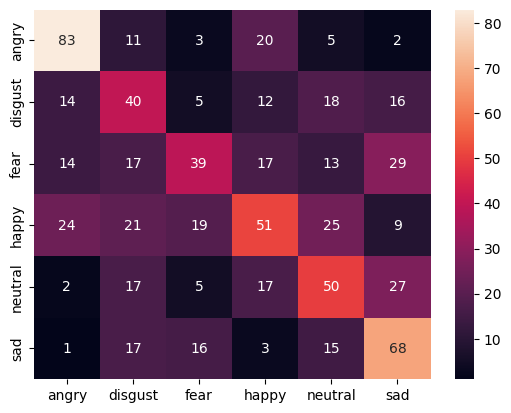

In [60]:
#Plot confusion matrix with results
ax = sns.heatmap(confusion_matrix, annot=True)

# Save CNN Model

In [61]:
from keras.models import model_from_json
# serialize model to json
json_model = CNN_model.to_json()
#save the model architecture to JSON file
with open('capstone_project_emotion_detection_final_version.json', 'w') as json_file:
    json_file.write(json_model)
#saving the weights of the model
CNN_model.save_weights('capstone_project_emotion_detection_final_version.h5')
#Model loss and accuracy
print("Saved model to disk")

Saved model to disk


In [62]:
# load json and create model
json_file = open('capstone_project_emotion_detection_final_version.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("capstone_project_emotion_detection_final_version.h5")
print("Loaded model from disk")

Loaded model from disk


In [63]:
from keras.initializers import glorot_uniform
#Reading the model from JSON file
with open('capstone_project_emotion_detection_final_version.json', 'r') as json_file:
    json_savedModel= json_file.read()
#load the model architecture
model_load = keras.models.model_from_json(json_savedModel)
model_load.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 32)            192       
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 128)           20608     
                                                                 
 conv1d_2 (Conv1D)           (None, 40, 64)            41024     
                                                                 
 conv1d_3 (Conv1D)           (None, 40, 32)            10272     
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0